# Airbnb Listings in Prague

## Introduction
This notebook explores the locations of Airbnb listings in Prague, downloaded from the Inside Airbnb portal. The dataset is available in CSV format from the following URL:


In [1]:
import contextily
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pointpats
import seaborn as sns
from matplotlib import patches
from sklearn import cluster

In [44]:
source = r"http://data.insideairbnb.com/czech-republic/prague/prague/2023-06-24/data/listings.csv.gz"
df_airbnb = pd.read_csv(source, compression='gzip')
df_airbnb_filt = df_airbnb[['id', 'name', 'latitude', 'longitude', 'price','neighborhood_overview', 'property_type']]
# convert price to float and fill na with 0
df_airbnb_filt.loc[:, 'price'] = df_airbnb_filt['price'].str.replace('$', '').str.replace(',', '').astype(float)

In [45]:
gdf_airbnb_filt = gpd.GeoDataFrame(
    df_airbnb_filt, geometry=gpd.points_from_xy(df_airbnb_filt['longitude'], df_airbnb_filt['latitude'], crs='EPSG:4326'))
gdf_airbnb_filt = gdf_airbnb_filt.to_crs("EPSG:5514")
gdf_airbnb_filt[["x", "y"]] = gdf_airbnb_filt.get_coordinates()


## Visualisation
- Create a hexbin visualisation of the listings
- Create a kernel density estimate of the distribution of Airbnb’s
- What can you read from the hexbin you cannot from the KDE and vice versa?

(array([-760000., -755000., -750000., -745000., -740000., -735000.,
        -730000., -725000., -720000.]),
 [Text(-760000.0, 0, '−760000'),
  Text(-755000.0, 0, '−755000'),
  Text(-750000.0, 0, '−750000'),
  Text(-745000.0, 0, '−745000'),
  Text(-740000.0, 0, '−740000'),
  Text(-735000.0, 0, '−735000'),
  Text(-730000.0, 0, '−730000'),
  Text(-725000.0, 0, '−725000'),
  Text(-720000.0, 0, '−720000')])

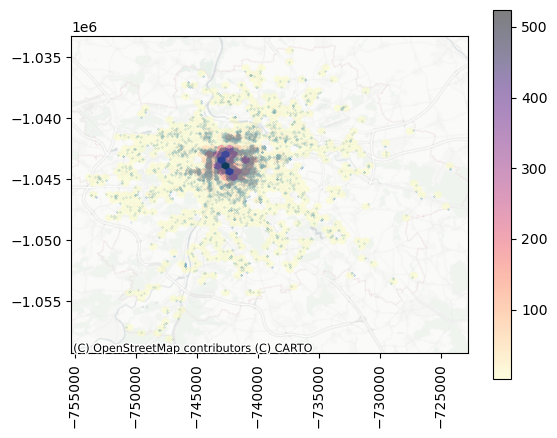

In [19]:
# hexbin
f, ax = plt.subplots()
gdf_airbnb_filt.plot(ax=ax, markersize=0.05)
hb = ax.hexbin(
    gdf_airbnb_filt["x"],
    gdf_airbnb_filt["y"],
    gridsize=45,
    linewidths=0,
    alpha=0.5,
    cmap="magma_r",
    mincnt=1,
)
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=gdf_airbnb_filt.crs,
    source="CartoDB Positron No Labels",
)
# Add colorbar
plt.colorbar(hb)
plt.xticks(rotation=90)

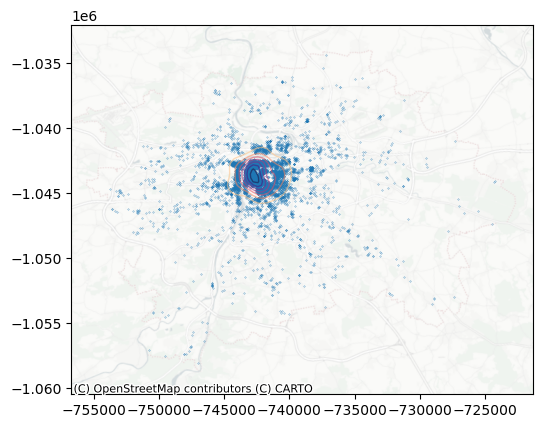

In [20]:
# kernel density
f, ax = plt.subplots()
gdf_airbnb_filt.plot(ax=ax, markersize=0.05)
pointpats.plot_density(
    gdf_airbnb_filt[["x", "y"]].values,
    bandwidth=500,
    levels=10,
    alpha=0.55,
    cmap="magma_r",
    linewidths=1,
    ax=ax,
)
contextily.add_basemap(
    ax=ax,
    crs=gdf_airbnb_filt.crs,
    source="CartoDB Positron No Labels",
)

## Centrography
- Measure mean, median, and mean weighted by a column of your choice.
- Can you plot them on a map?
- Are they the same? Can you tell why?

In [27]:
mean_center = pointpats.centrography.mean_center(gdf_airbnb_filt[["x", "y"]])
med_center = pointpats.centrography.euclidean_median(gdf_airbnb_filt[["x", "y"]])
gdf_airbnb_filt["price"].describe()
weighted_mean = pointpats.centrography.weighted_mean_center(
    gdf_airbnb_filt[["x", "y"]], gdf_airbnb_filt["price"]
)
print(f'Mean center: {mean_center}')
print(f'Median center: {med_center}')
print(f'Weighted mean center: {weighted_mean}')

Mean center: [ -742266.15196173 -1043826.48371407]
Median center: [ -742449.51386627 -1043764.90565231]
Weighted mean center: [ -742364.22780964 -1043780.64534778]


(array([-748000., -746000., -744000., -742000., -740000., -738000.,
        -736000.]),
 [Text(-748000.0, 0, '−748000'),
  Text(-746000.0, 0, '−746000'),
  Text(-744000.0, 0, '−744000'),
  Text(-742000.0, 0, '−742000'),
  Text(-740000.0, 0, '−740000'),
  Text(-738000.0, 0, '−738000'),
  Text(-736000.0, 0, '−736000')])

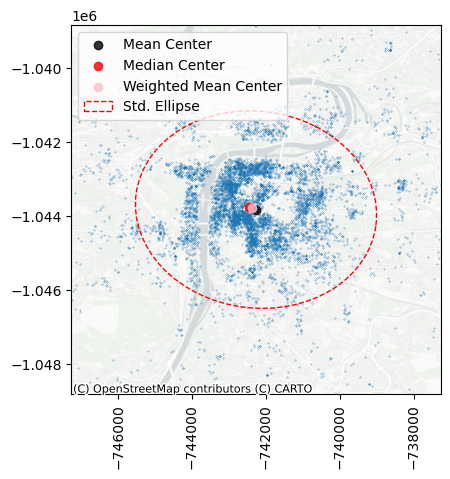

In [ ]:
major, minor, rotation = pointpats.centrography.ellipse(gdf_airbnb_filt[["x", "y"]])
f, ax = plt.subplots()
gdf_airbnb_filt.plot(ax=ax, markersize=0.05)

ax.scatter(*mean_center, color="k", marker="o", label="Mean Center", alpha=0.8)
ax.scatter(*med_center, color="r", marker="o", label="Median Center", alpha=0.8)
ax.scatter(
    *weighted_mean,
    color="pink",
    marker="o",
    label="Weighted Mean Center",
    alpha=0.8
)

ellipse = patches.Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.rad2deg(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)
ax.legend(loc="upper left")


ax.set_xlim(mean_center[0] - 5000, mean_center[0] + 5000)
ax.set_ylim(mean_center[1] - 5000, mean_center[1] + 5000)

contextily.add_basemap(
    ax=ax,
    crs=gdf_airbnb_filt.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90)

## Randomness
- Measure quadrat statistic. How does it change when you change the grid size?
- Measure Ripley’s K and L functions.
- Is the pattern clustered?


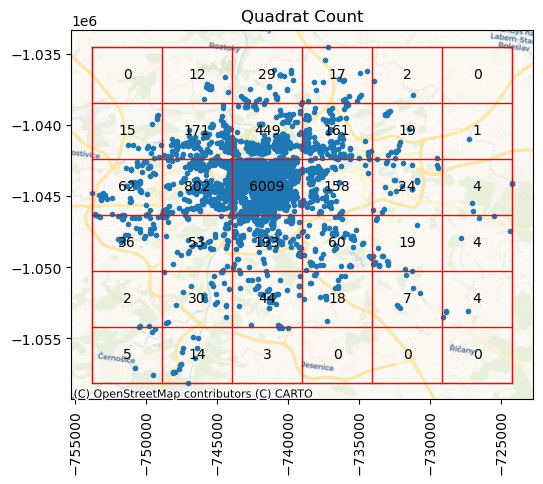

In [38]:
qstat = pointpats.QStatistic(gdf_airbnb_filt[["x", "y"]].values, nx=6, ny=6)

ax = qstat.plot()
contextily.add_basemap(
    ax=ax,
    crs=gdf_airbnb_filt.crs,
    source="CartoDB Voyager",
)
plt.xticks(rotation=90);

In [40]:
concave_hull = gdf_airbnb_filt.dissolve().concave_hull(ratio=.5)

g_test = pointpats.distance_statistics.g_test(
    gdf_airbnb_filt[["x", "y"]].values,
    support=200,
    keep_simulations=True,
    hull=concave_hull.item(),
    n_simulations=500,
)

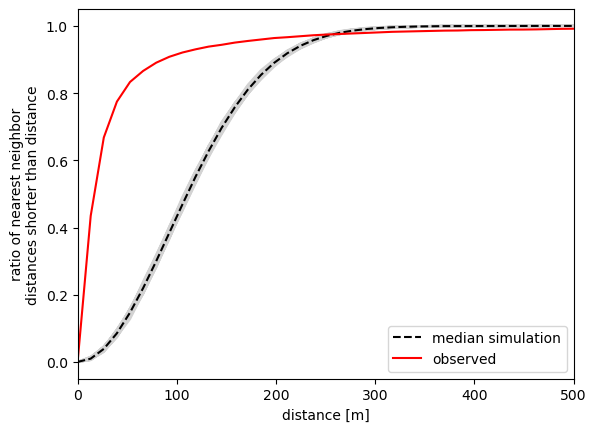

In [41]:
f, ax = plt.subplots()
ax.plot(g_test.support, g_test.simulations.T, color="lightgrey")
ax.plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="k",
    label="median simulation",
    linestyle="--",
)
ax.plot(g_test.support, g_test.statistic, label="observed", color="red")
ax.set_xlabel("distance [m]")
ax.set_ylabel(
    "ratio of nearest neighbor\n"
    "distances shorter than distance"
)
ax.legend()
ax.set_xlim(0, 500);

In [42]:
f_test = pointpats.distance_statistics.f_test(
    gdf_airbnb_filt[["x", "y"]].values,
    support=200,
    keep_simulations=True,
    hull=concave_hull.item(),
    n_simulations=500,
)

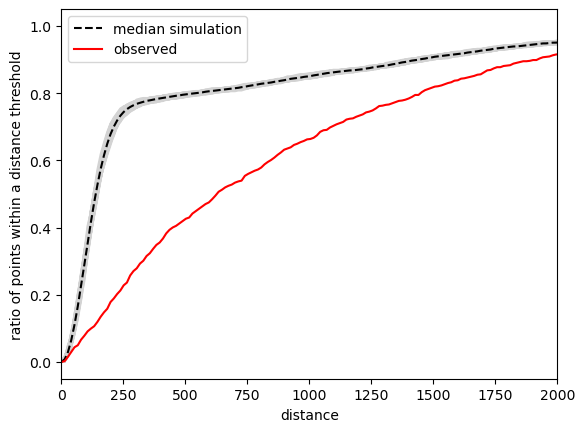

In [43]:
f, ax = plt.subplots()
ax.plot(f_test.support, f_test.simulations.T, color="lightgrey")
ax.plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="k",
    label="median simulation",
    linestyle="--",
)
ax.plot(f_test.support, f_test.statistic, label="observed", color="red")
ax.set_xlabel("distance")
ax.set_ylabel("ratio of points within a distance threshold")
ax.legend()
ax.set_xlim(0, 2000);